<a href="https://colab.research.google.com/github/cis9650group7-boop/Group-7_Project1_HealthRateAnalysis/blob/main/term_project_group7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Analysis of Health Rate

### Author: CIS 9650 Group 7 (Anish Bijusoman, Ivana Sundararao, Qingrong Tan, Reem Hussein)
### Date : November 28th, 2025

## Executive Summary

## Table of Contents

1. Introduction
2. Problem Statement / Research Question
3. Data Description
4. Setup and Environment
5. Data Loading
6. Data Preparation
7. Modeling and Analysis
8. Conclusion
9. References

## Introduction

This project analyzes doctor ratings in New York using a real-world dataset. Our goal is to understand how doctor quality varies across specialties and locations, and to identify meaningful patterns in patient satisfaction.  

Because the dataset contains over 1,500 raw columns, we focused on selecting a clean and relevant subset of variables that support clear and actionable insights.  

The analysis presented can help decision makers understand trends in physician ratings across New York State.


## Problem Statement / Research Question
The goal of this project is to understand what drives variation in doctor ratings across medical providers in New York State.

Although the dataset includes thousands of providers, the reasons behind high or low patient ratings are not immediately clear.

To investigate these patterns, the analysis is guided by the following research questions:

*   Do doctor ratings differ across medical specialties?
*   What do patient reviews reveal about the reasons for high versus low ratings?
*   How strongly do individual sub-ratings influence the overall rating?
*   Which factors are the strongest predictors of a doctor’s overall rating?
*   Do location or facility characteristics influence patient satisfaction?



## Data Description

The dataset contains patient review records for medical providers across a wide range of specialties in New York State. It provides structured information on providers, their clinic locations, and detailed patient ratings. Each row represents a single medical provider or practice, and each column describes attributes related to provider identity, specialty, location, operational features, and rating performance.

Dataset file type: CSV\
Number of rows: 143,791\
Number of columns: 1,611

Key Categories of columns:
1. Provider Information: \
Basic details identifying each medical provider, including name, specialty, and related classification fields.
2. Rating Information\
Overall ratings, sub-ratings (staff, punctuality, helpfulness), review counts, and patient comments.
3. Location Information\
Clinic names, addresses, postal codes, city names, and geographic coordinates (latitude/longitude).
4. Metadata and Identifiers\
System IDs and timestamps, such as record IDs, creation dates, and modification dates.
5. URLs and Media Fields\
Website links, profile URLs, and image URLs associated with providers and clinic locations.
6. Appointment and Verification Information\
Boolean fields indicating whether a provider is verified, offers appointment features, or has promotional enhancements.
7. Additional Clinic Details\
Secondary clinic locations, extended address details, images, and related attributes.
8. Business Hours\
Operating hours for each clinic or practice.

## Setup and Environment

In [67]:
!pip install google-cloud-storage

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px
import json
import os
import statsmodels.api as sm
from io import BytesIO
from collections import Counter
try:
  from google.cloud import storage
except:
  print('google.cloud not available')


## Data Loading

In [69]:
# Download a CSV file from a public Google Clode Storage bucket

def gcs_file_to_dataframe(bucket_name, blob_path, local_path, use_cols):

  # Attempt 1 to load csv from Google Clode Storage first
  try:
    # Anonymous client for public buckets
    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_path)

    # Download file content as bytes
    data = blob.download_as_bytes()

    # Only read columns we use
    df = pd.read_csv(BytesIO(data),usecols = use_cols)
    print('Successfully loaded data from Google Cloud Storage.')
    return df
  except Exception as e:
    print(f'Failed to load dataset from Google Cloud Storage:{e}')
    print('Attempting to switch to local file loading...')


  # Attempt 2 to load csv from local file
  try:
    if os.path.exists(local_path):
      df = pd.read_csv(local_path, usecols = use_cols)
      print('Successfully loaded data from local file.')
      return df
    else:
      print(f'Local file does not exist: {local_path}')
      return None
  except Exception as e:
    print(f'Local load also failed: {e}')
    return None



In [70]:
# Load the csv file into a Pandas dataframe

# Set local CSV file path
# If running locally, please update this to your actual local path
local_csv_path = 'healthrate.ratemd.ny.csv'

# Set bucket parameters for "msba-online-data/CIS9650/Project 01"
BUCKET_NAME = "msba-online-data"
cloud_csv_path = "CIS9650/Project 01/healthrate.ratemd.ny.csv"

#List the columns needed to load
columns_load = ["_id",
                "full_name",
                "specialty_name",
                "location.city.name",
                 "rating.average",
                 "rating.helpfulness",
                 "rating.punctuality",
                  "rating.staff",
                 "rating.count",
                "sample_rating_comment"]


df = gcs_file_to_dataframe(BUCKET_NAME,  cloud_csv_path, local_csv_path, columns_load)

if df is None:
  print(
      'Error: Failed to load dataset.\n'
      'Cloud dataset could not be accessed.\n'
      'Local data set not found.\n'
  )
  raise SystemExit

print(df.head())
print(f'Rows:{len(df)}')


Successfully loaded data from Google Cloud Storage.
                        _id              full_name location.city.name  \
0  647e89e399dca372f92a0d7c    Dr. Janan S. Sayyed      New York City   
1  647e89e499dca372f92a0d91      Dr. Shirin Peters      New York City   
2  647e89e499dca372f92a0db9      Thomas J. Mulhern      New York City   
3  647e89e499dca372f92a0dba            Zina Rutkin         Great Neck   
4  647e89e499dca372f92a0dbd  Dr. John S. Cavallaro           Brooklyn   

   rating.average  rating.staff  rating.punctuality  rating.helpfulness  \
0        4.989221       4.99005            4.985075            4.993367   
1        5.000000       5.00000            5.000000            5.000000   
2        0.000000       0.00000            0.000000            0.000000   
3        0.000000       0.00000            0.000000            0.000000   
4        0.000000       0.00000            0.000000            0.000000   

   rating.count                              sample_rating

## Data Preparation

The raw data set from the CSV file contained 1,611 columns and 143,791 rows. That in itself is too much to analyze, and also contained fields such as images, phone numbers, etc... Field that would be irrelivant to our analysis, and research question. So this calls for some data cleaning!

* We selected a focused subset of relevant variables that describe each doctor’s name, specialty, city,core rating metrics, ect.

* We renamed the columns to simpler names. Column names were written such as "location.city.name", "rating.average" so we changed them to "city" and "rating_average"

* Rating fields were stored as mixed text/numeric types so we converted the rating columns to numeric using pd.to_numeric(df_clean[col], errors="coerce")

* We filtered out zero rating doctors to make sure we only analyze doctors who have actual patient reviews in order to produce valid insights

* After filtering, we reset the index for smooth readability.

In [71]:
# ---------- DATA CLEANING ----------
# Select usable columns
cols_to_keep = [
    "_id", "full_name", "specialty_name", "location.city.name",
    "rating.average", "rating.helpfulness", "rating.punctuality",
    "rating.staff", "rating.count","sample_rating_comment"
]

df_clean = df[cols_to_keep].copy()

# Rename columns to simpler names
df_clean = df_clean.rename(columns={
    "location.city.name": "city",
    "rating.average": "rating_avg",
    "rating.helpfulness": "rating_help",
    "rating.punctuality": "rating_punctuality",
    "rating.staff": "rating_staff",
    "rating.count": "rating_count"
})

# Convert numeric columns to proper numeric types
numeric_cols = [
    "rating_avg", "rating_help", "rating_punctuality",
    "rating_staff", "rating_count"
]

for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

# Drop rows with no rating information
df_clean = df_clean.dropna(subset=["rating_avg"])

# Before having this the rating avg and rating_help was 0's
df_clean = df_clean[df_clean["rating_count"] > 0]
df_clean = df_clean[df_clean["rating_avg"] > 0]

# Reset index
df_clean = df_clean.reset_index(drop=True)

df_clean.head() # this is to see the clean data

,_id,full_name,specialty_name,city,rating_avg,rating_help,rating_punctuality,rating_staff,rating_count,sample_rating_comment
0,647e89e399dca372f92a0d7c,Dr. Janan S. Sayyed,Chiropractor,New York City,4.989221,4.993367,4.985075,4.99005,603,I had chiropractic adjustments and it was gre...
1,647e89e499dca372f92a0d91,Dr. Shirin Peters,Internist / Geriatrician,New York City,5.000000,5.000000,5.000000,5.00000,48,If your looking for an internist who will trea...
2,647e89e499dca372f92a0e14,Dr. Lev L. Barats,Internist / Geriatrician,Slingerlands,4.000000,3.800000,4.100000,3.80000,10,Dr. Barats is very friendly and intelligent. H...
3,647e89e499dca372f92a0ef0,Dr. Harold N. Bornstein,Internist / Geriatrician,New York City,4.000000,4.200000,3.800000,4.20000,10,He should be fired for revealing confidential ...
4,647e89e499dca372f92a0ef2,Dr. Romelle J. Maloney,Gynecologist (OBGYN),New Rochelle,4.000000,3.900000,4.100000,3.80000,10,"Dr. Maloney, It was wonderful to meet you. Y..."


In [72]:
df.head(10) # this is unclean data

,_id,full_name,location.city.name,rating.average,rating.staff,rating.punctuality,rating.helpfulness,rating.count,sample_rating_comment,specialty_name
0,647e89e399dca372f92a0d7c,Dr. Janan S. Sayyed,New York City,4.989221,4.99005,4.985075,4.993367,603,I had chiropractic adjustments and it was gre...,Chiropractor
1,647e89e499dca372f92a0d91,Dr. Shirin Peters,New York City,5.000000,5.00000,5.000000,5.000000,48,If your looking for an internist who will trea...,Internist / Geriatrician
2,647e89e499dca372f92a0db9,Thomas J. Mulhern,New York City,0.000000,0.00000,0.000000,0.000000,0,NaN,Psychologist
3,647e89e499dca372f92a0dba,Zina Rutkin,Great Neck,0.000000,0.00000,0.000000,0.000000,0,NaN,Psychologist
4,647e89e499dca372f92a0dbd,Dr. John S. Cavallaro,Brooklyn,0.000000,0.00000,0.000000,0.000000,0,NaN,Dentist
5,647e89e499dca372f92a0dc3,Dr. Keith P. Gutzmann,Howard Beach,0.000000,0.00000,0.000000,0.000000,0,NaN,Chiropractor
6,647e89e499dca372f92a0de4,Dr. Aruna Mishra,New York City,0.000000,0.00000,0.000000,0.000000,0,NaN,Gynecologist (OBGYN)
7,647e89e499dca372f92a0df1,Dr. Jonathan D. Porter,Syracuse,0.000000,0.00000,0.000000,0.000000,0,NaN,Dentist
8,647e89e499dca372f92a0dfe,Dr. Andrzej Riess,New York City,0.000000,0.00000,0.000000,0.000000,0,NaN,Gynecologist (OBGYN)
9,647e89e499dca372f92a0e14,Dr. Lev L. Barats,Slingerlands,4.000000,3.80000,4.100000,3.800000,10,Dr. Barats is very friendly and intelligent. H...,Internist / Geriatrician


## Modeling and Analysis


### Analysis 1: Specialty-Level Rating Variation and Insights from Patient Feedback


*How ratings vary between different specialties*





In [73]:
# Model Planning for Analysis 1:Specialty-Level Rating Variation and Insights from Patient Feedback

# ------- Calculations ------

# 1.Create a working copy
specialty_df = df_clean.copy()
print("--- Starting Weighted Agrregation Calculation---")

# 2. Calculate Weighted Sum (Score Points)
# Weighted Sum = Average Rating * Rating Count
specialty_df['weighted_sum'] = specialty_df['rating_avg'] * specialty_df['rating_count']

#3. Calculate the summary for each specialty
specialty_grouped_df = specialty_df.groupby('specialty_name')
specialty_result_df = specialty_grouped_df.agg(
    total_score_sum =('weighted_sum','sum'),  # Total Score Points for a specialty
    total_count = ('rating_count','sum'), # Toal rating_count for a specialty
    num_doctors = ('_id','nunique') # Total numbers of doctors for a specialty
)

#4. Reset the index
specialty_result_df = specialty_result_df.reset_index()

#5. Calculate weighted average rating
specialty_result_df['final_average_rating'] = specialty_result_df['total_score_sum'] / specialty_result_df['total_count']


# ------ Filter out outliers (specialties with very low rating counts - bottom 25th percentile) ------

# 1. Calculate the percentle threshold for total_count
threshold_percentile = specialty_result_df['total_count'].quantile(0.25) #25%
print(f"The 25th percentile rating count threshold: {threshold_percentile}")

# 2. Apply the filter
specialty_result_df = specialty_result_df[specialty_result_df['total_count'] >= threshold_percentile]

# 3. Rank the remaning specialties (final_average_rating DESC).
specialty_result_df = specialty_result_df.sort_values(by = 'final_average_rating', ascending = False)

#print(specialty_result_df)


--- Starting Weighted Agrregation Calculation---
The 25th percentile rating count threshold: 165.25


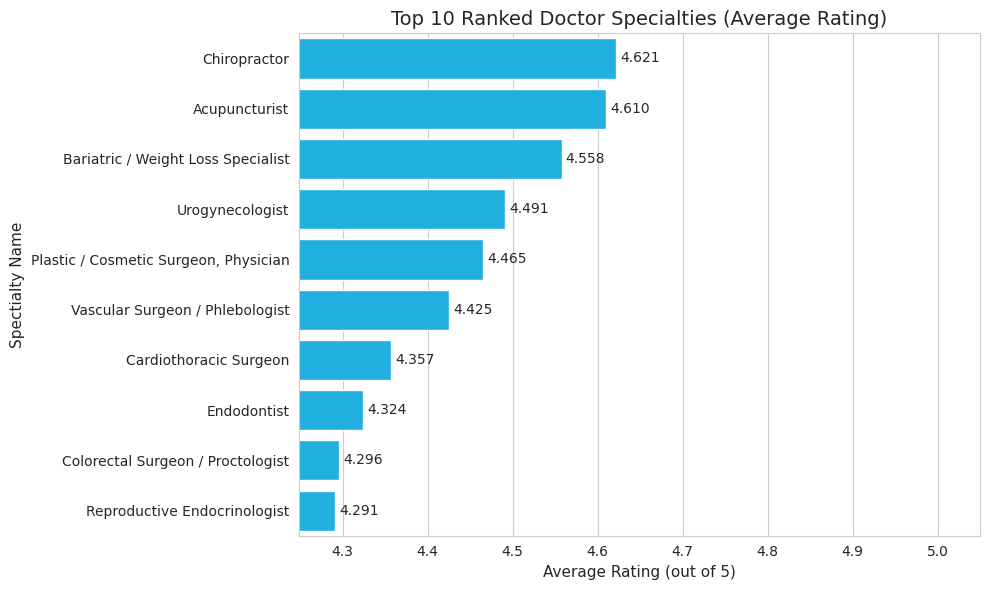

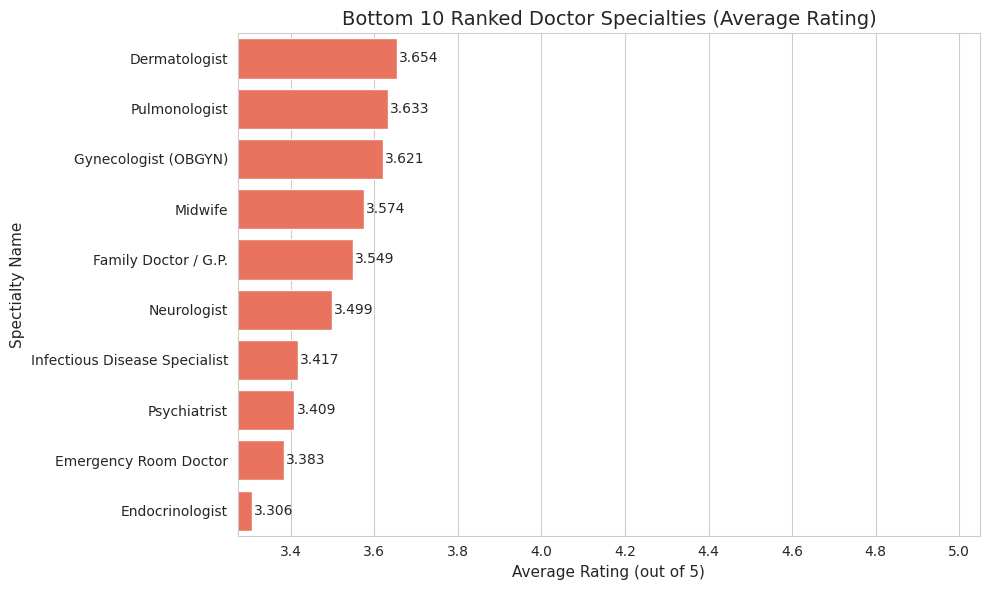

In [74]:
# Model building for Analysis 1: the differences in doctor ratings across different specialties
# specialty_result_df is the dataframe already containing rows order by final_average_rating DESC

# ------- Modeling ------

# Top 10 Bar Chart
# 1. Prepare Top 10 df
top_10_df = specialty_result_df.head(10).copy()

# 2. Sort the plotting data by rating ASC for correct chart display
top_10_df = top_10_df.sort_values(by='final_average_rating', ascending=True)

#3. Create Top 10 Horizontal Bar Chart
plt.figure(figsize=(10,6))
sns.barplot(
    x = 'final_average_rating',
    y = 'specialty_name',
    data = top_10_df,
    color = 'deepskyblue'
)
plt.title('Top 10 Ranked Doctor Specialties (Average Rating)', fontsize = 14)
plt.xlabel('Average Rating (out of 5)', fontsize = 11)
plt.ylabel('Spectialty Name', fontsize = 11)

# Add value for each bar
for index, value in enumerate(top_10_df['final_average_rating']):
  plt.text(
      value + 0.005,
      index,
      f'{value:.3f}',
      ha = 'left',
      va = 'center',
      fontsize = 10
  )

# Invert the y-axis to show the highest rated specialty at the top
plt.gca().invert_yaxis()
plt.xlim(top_10_df['final_average_rating'].min() * 0.99, 5.05)
plt.tight_layout()
plt.show()



# Bottom 10 Bar Chart
# 1. Prepare bottom 10 df
bottom_10_df = specialty_result_df.tail(10).copy()

# 2. Sort the plotting data by rating ASC for correct chart display
bottom_10_df = bottom_10_df.sort_values(by='final_average_rating', ascending=True)

#3. Create Bottom 10 Horizontal Bar Chart
plt.figure(figsize=(10,6))
sns.barplot(
    x = 'final_average_rating',
    y = 'specialty_name',
    data = bottom_10_df,
    color = 'tomato'
)
plt.title('Bottom 10 Ranked Doctor Specialties (Average Rating)', fontsize = 14)
plt.xlabel('Average Rating (out of 5)', fontsize = 11)
plt.ylabel('Spectialty Name', fontsize = 11)

# Add value for each bar
for index, value in enumerate(bottom_10_df['final_average_rating']):
  plt.text(
      value + 0.005,
      index,
      f'{value:.3f}',
      ha = 'left',
      va = 'center',
      fontsize = 10
  )

# Invert the y-axis to show the highest rated specialty at the top
plt.gca().invert_yaxis()
plt.xlim(bottom_10_df['final_average_rating'].min() * 0.99, 5.05)
plt.tight_layout()
plt.show()






*What do patients talk about? (sample_rating_comment)*

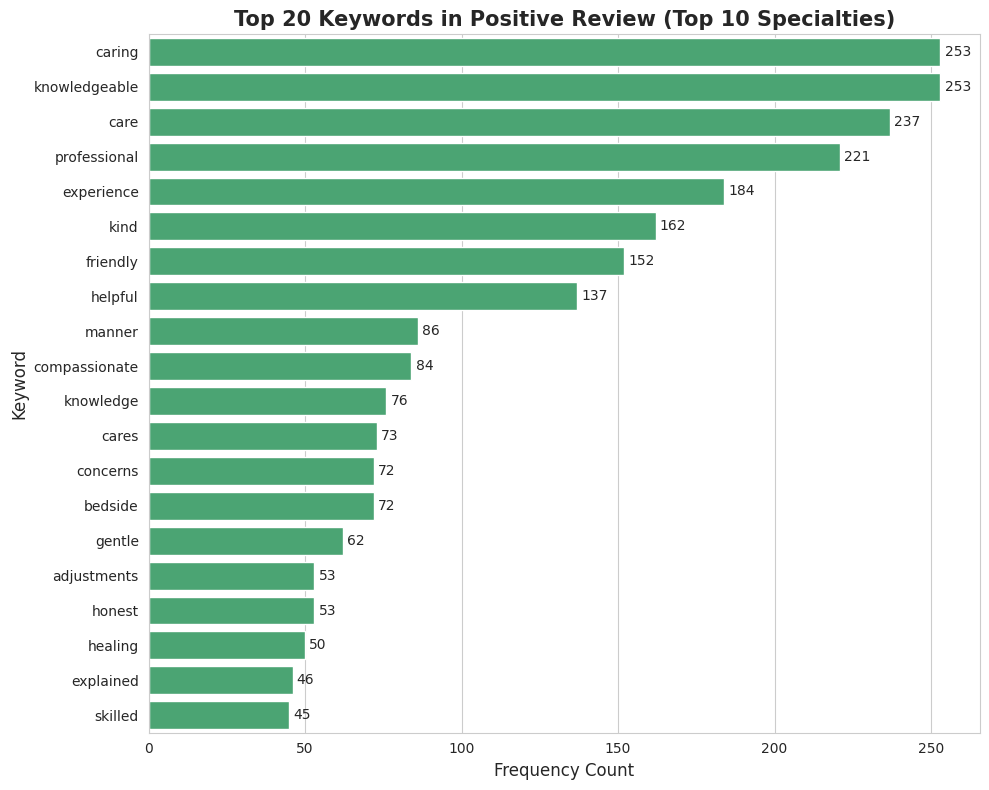

In [75]:
# Analysis of Top 10 Specialties' Positive Keywords

# 1. Create a dataframe for comment analysis
comments_df = df_clean.copy()

# 2. Get the list of top 10 specialty name
top_10_names = specialty_result_df.head(10)['specialty_name'].tolist()
#print(f'Top 10 Specialties: {top_10_names}')

# 3. Filter Data:
top_10_reviews = comments_df[
    (comments_df['specialty_name'].isin(top_10_names)) &
    (comments_df['rating_avg'] >= 4.29) &
    (comments_df['sample_rating_comment'].notna())

    ]
#print(f'Number of comments extracted: {len(top_10_reviews)}')

# 4. Combine all comments into one large string
all_text = ' '.join(top_10_reviews['sample_rating_comment'].astype(str).tolist())

# 5. Convert to lowercase, replace any charaters that is not a word charater or a whitespace charater
all_text = re.sub(r'[^\w\s]',' ', all_text).lower()

# 6. A set of common words that need to ignore
words_to_ignore = {'the','and','to','a','of','was','is','in','for','my','she','he','it','with','very','that',
    'at','on','her','his','i','me','you','are','we','they','them','our','your','there','anyone','being',
    'dr','doctor','doctors','patient','patients','office','staff','visit','appointment','time','day',
    'year','years','person','issues','everything','health','thank','thanks','please',
    'great','good','best','better','excellent','amazing','wonderful','fantastic','awesome','incredible',
    'truly','happy','comfortable','really','so','too','quite','super','extremely','well','first','only','just',
    'even','still','then','than','now','ever','never','enough','made','make','get','got','give','gave','take','took','felt','feel','went','came','see','seen','say',
    'says','said','look','looks','know','knew','done','did','does','doing','help','helped','helps','able','need','needs','like','liked','likes','want','wanted','wanting',
    'but','and','or','if','when','while','because','also','just','even','only','still','then','than',
    'though','however','although','from','this','that','these','those','about','around','after','before',
    'over','under','into','out','one','will','can','could','would','were','been','has','have','had','not','many','much','any','every','few','lot','lots','more','most','some','several','again',
    'who','what','how','where','why','which','him','amp','work','having','seeing','found','treated','needed','without','visits','things','sure',
    'during','since','ago','new','weeks','months','free','friends','everyone','team',
    'feeling','all','highly','always','other','going','family','take','through','results','life','their','body','recommend','recommended','takes','way','right','thorough','ploblem',	'both','don','two','times','long','each','entire','down','left','such',
    'people','practice','job','love','easy','tell','come','gone','met','looking','explain','definitely','absolutely','next','makes','whole','should','process',
    'lower','far','same','else','positive','saw','face','root','plastic','knowledgable','nice','questions','pain','back','surgery','treament','chiropractor','surgeon','neck','chiropractic','procedure','treatment','treatments',
    'acupuncture','problems','problem','chiropractors','medical','breast','acupuncturist','hands','therapy','relief'
    }

# 7. Split
comment_words = all_text.split()

# 8. Filter: Keep words not in words_to_ignore and longer than 2 charaters
meaningful_words = [mw for mw in comment_words if mw not in words_to_ignore and len(mw) > 2 ]

# 9. Count the top 20 most frequent words
word_counts = Counter(meaningful_words)
top_keywords_df = pd.DataFrame(word_counts.most_common(20), columns = ['Keyword','Frequency'])
#print(top_keywords_df)

# 10. Chart
sns.set_style('whitegrid')  # Set the visual style for the plot
plt.figure(figsize=(10,8))  # Set the font size of the chart

# Creat a horizontal bar plot
ax = sns.barplot(
    x = 'Frequency',
    y = 'Keyword',
    data = top_keywords_df,
    color = 'mediumseagreen'
)

# Add title and lables
plt.title('Top 20 Keywords in Positive Review (Top 10 Specialties)', fontsize = 15, fontweight = 'bold')
plt.xlabel('Frequency Count',fontsize = 12)
plt.ylabel('Keyword', fontsize = 12)

# Add the frequency number at the end of each bar
for inumber in ax.containers:
  ax.bar_label(inumber,padding = 3)

plt.tight_layout()
plt.show()






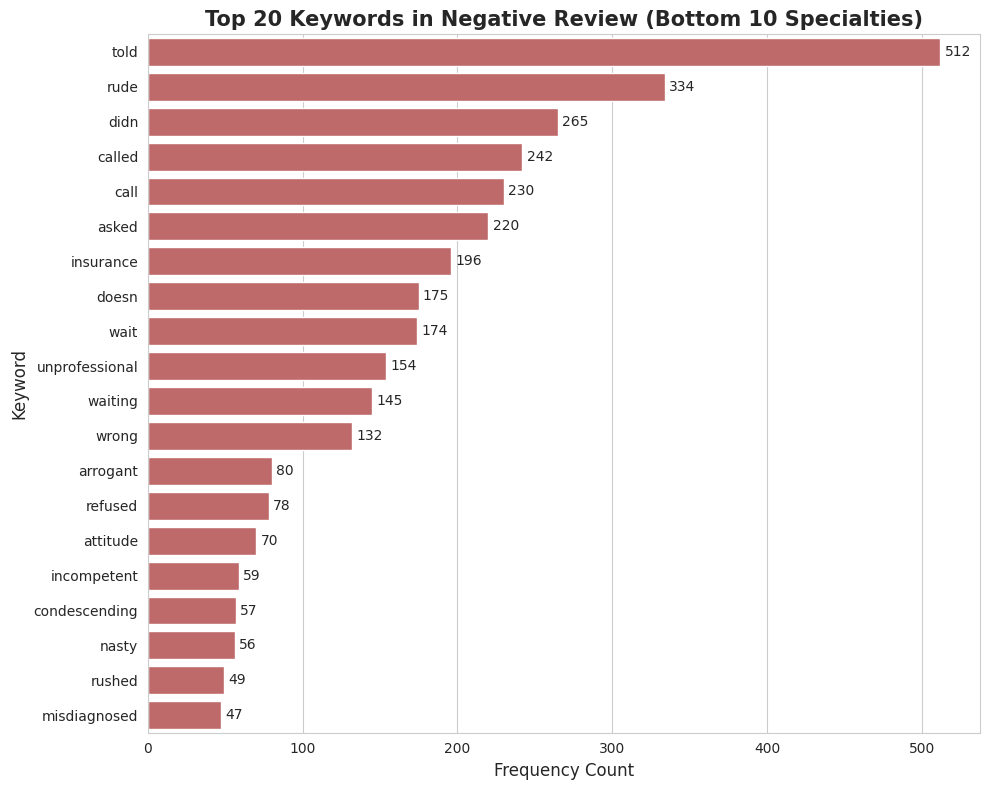

In [76]:
#Analysis of Bottom 10 Specialties' Negative Keywords
# 1. Create a dataframe for comment analysis
comments_df2 = df_clean.copy()

# 2. Get the list of bottom 10 specialty name
bottom_10_names = specialty_result_df.tail(10)['specialty_name'].tolist()
#print(f'Bottom 10 Specialties: {bottom_10_names}')

# 3. Filter Data: Focus on Bottom 10 + Low Ratings (<= 2.5)
bottom_10_reviews = comments_df2[
    (comments_df2['specialty_name'].isin(bottom_10_names)) &
    (comments_df2['rating_avg'] <= 2.5) &
    (comments_df2['sample_rating_comment'].notna())
]
#print(f'Number of negative comments extracted: {len(bottom_10_reviews)}')

# 4. Combine all comments into one large string
all_text2 = ' '.join(bottom_10_reviews['sample_rating_comment'].astype(str).tolist())

# 5. Convert to lowercase, replace any characters that is not a word character or a whitespace character
all_text2 = re.sub(r'[^\w\s]',' ', all_text2).lower()

# 6. A set of common words that need to ignore
words_to_ignore2 = {
    'the','and','to','a','of','was','is','in','for','my','she','he','it','with','very','that',
    'at','on','her','his','i','me','you','are','we','they','them','our','your','there','anyone','being',
    'dr','doctor','doctors','patient','patients','office','staff','visit','appointment','time','day',
    'year','years','person','issues','everything','health','thank','thanks','please',
    'truly','happy','comfortable','really','so','too','quite','super','extremely','well','first','only','just',
    'even','still','then','than','now','ever','never','enough','made','make','get','got','give','gave','take','took','felt','feel','went','came','see','seen','say',
    'says','said','look','looks','know','knew','done','did','does','doing','help','helped','helps','able','need','needs','like','liked','likes','want','wanted','wanting',
    'but','or','if','when','while','because','also','though','however','although','from','this','these','those','about','around','after','before',
    'over','under','into','out','one','will','can','could','would','were','been','has','have','had','not','many','much','any','every','few','lot','lots','more','most','some','several','again',
    'who','what','how','where','why','which','him','amp','work','having','seeing','found','treated','needed','without','visits','things','sure',
    'during','since','ago','new','weeks','months','free','friends','everyone','team',
    'feeling','all','highly','always','other','going','family','through','results','life','their','body','recommend','recommended','takes','way','right','thorough',
    'both','don','two','times','long','each','entire','down','left','such',
    'people','practice','job','love','easy','tell','come','gone','met','looking','explain','definitely','absolutely','next','makes','whole','should','process',
    'lower','far','same','else','saw','face','nice','questions','back','neck',
    'medical','hands','care', 'another', 'away', 'experience', 'good', 'hospital', 'find', 'off',
    'test', 'stay', 'later', 'child', 'blood', 'days', 'woman', 'better',
    'someone', 'here', 'exam', 'prescribed', 'sent', 'son', 'medicine', 'tests',
    'mother', 'nurse', 'symptoms','pain', 'medication', 'minutes', 'something', 'last', 'tried', 'man',
    'appointments', 'pay', 'put', 'waited', 'physician', 'instead', 'ask',
    'taking', 'meds', 'husband', 'diagnosis', 'wife', 'late', 'problem',
    'actually', 'calls', 'wasn', 'side', 'hour', 'hours', 'think','room','nothing','surgery', 'different', 'speak', 'let', 'getting', 'completely',
    'month', 'avoid', 'until', 'cold', 'front', 'seems', 'due',
    'great', 'knowledge', 'old', 'once', 'seemed', 'talk',
    'prescription', 'trying', 'problems', 'condition', 'place',
    'myself', 'second', 'waste','finally', 'use', 'helpful', 'psychiatrist', 'leave', 'little', 'almost',
    'medications', 'thing', 'making', 'information', 'point', 'baby', 'daughter',
    'wouldn', 'believe', 'answer', 'week', 'cancer', 'check', 'run', 'emergency',
    'cannot', 'couldn', 'infection', 'sick','professional','phone','treatment','anything', 'bedside', 'finally', 'concerns', 'receptionist',
    'understand', 'less', 'talking', 'records', 'herself', 'service','thought', 'procedure', 'reviews', 'saying', 'may', 'asking',
    'received', 'review', 'personal', 'least', 'working', 'given','three', 'bill', 'home', 'paid', 'fact', 'kept', 'lack', 'check','run', 'week', 'baby', 'daughter', 'little', 'almost',
    'information', 'point', 'making','money','listen','follow','treat','worst','bad','poor','horrible','terrible','awful','mental','today','worse','taken','issue','manner','question','started','pregnancy','kind','care','diagnosed','caring'
}

# 7. Split
comment_words2 = all_text2.split()

# 8. Filter: Keep words not in words_to_ignore and longer than 2 characters
meaningful_words2 = [mw2 for mw2 in comment_words2 if mw2 not in words_to_ignore2 and len(mw2) > 2 ]

# 9. Count the top 20 most frequent words
word_counts2 = Counter(meaningful_words2)
bottom_keywords_df = pd.DataFrame(word_counts2.most_common(20), columns = ['Keyword','Frequency'])

#print('\nBottom 10 Specialties: Key Words in Negative Reviews')
#print(bottom_keywords_df)

# 10. Chart
sns.set_style('whitegrid')  # Set the visual style for the plot
plt.figure(figsize=(10,8))  # Set the font size of the chart

# Creat a horizontal bar plot
ax = sns.barplot(
    x = 'Frequency',
    y = 'Keyword',
    data = bottom_keywords_df,
    color = 'indianred'
)

# Add title and lables
plt.title('Top 20 Keywords in Negative Review (Bottom 10 Specialties)', fontsize = 15, fontweight = 'bold')
plt.xlabel('Frequency Count',fontsize = 12)
plt.ylabel('Keyword', fontsize = 12)

# Add the frequency number at the end of each bar
for inumber in ax.containers:
  ax.bar_label(inumber,padding = 3)

plt.tight_layout()
plt.show()

**Insight 1: Specialty-Level Rating Variation and Insights from Patient Feedback**

The analysis begins by comparing the average ratings across medical specialties to see whether meaningful differences exist. A clear gap appears between the highest-rated and lowest-rated specialties. The top-rated specialties, such as Chiropractor, Acupuncturist, and Bariatric/Weight-Loss, consistently receive average ratings above 4.5. In contrast, specialties such as Endocrinology, Emergency Medicine, Neurology, and Psychiatry show much lower averages, generally between 3.3 and 3.6.

To understand what may be causing these differences, patient comments were examined for both the top 10 and bottom 10 specialties. Positive reviews for high-rated specialties often include words like “caring,” “knowledgeable,” “professional,” “experience,” and “skilled.” These patterns suggest that patients value both the provider’s interpersonal approach and their technical ability, experience, and expertise. In comparison, common terms in negative reviews include “told,” “called,” “rude,” “wait,” “unprofessional,” “attitude,” “arrogant,” and “misdiagnosed.” These words show that dissatisfaction in low-rated specialties is strongly linked to communication issues, long wait times, and negative provider behavior. Although some comments refer to technical concerns, such as “wrong” or “misdiagnosed,” these occur less often than complaints about personal interaction or services.


##Analysis 2: Correlation between Helpfulness and Overall Rating

In [77]:
# INSIGHT 2: Correlation Between Helpfulness and Overall Rating

# Make a separate copy so we don't touch df_clean
df_help = df_clean.copy()

# Drop rows where helpfulness or rating are missing
df_help = df_help.dropna(subset=["rating_avg", "rating_help"])

# Compute correlation
corr_value = df_help["rating_help"].corr(df_help["rating_avg"])
corr_value


np.float64(0.9640779591585897)

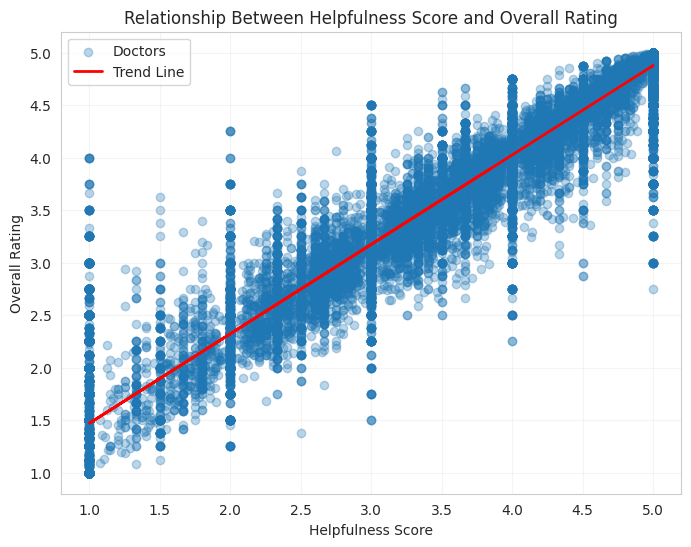

In [78]:


# Values for plot
x = df_help["rating_help"]
y = df_help["rating_avg"]

# Fit regression line
m, b = np.polyfit(x, y, 1)

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.3, label="Doctors")
plt.plot(x, m*x + b, color="red", linewidth=2, label="Trend Line")

plt.title("Relationship Between Helpfulness Score and Overall Rating")
plt.xlabel("Helpfulness Score")
plt.ylabel("Overall Rating")
plt.legend()
plt.grid(alpha=0.2)
plt.show()


##Analysis 3: Relative Impact of Sub‐Ratings on Overall Doctor Rating

### 1.  Compute Pearson correlations

In [79]:
# 1. Compute Pearson correlations
corr_help = df_clean["rating_help"].corr(df_clean["rating_avg"])
corr_punct = df_clean["rating_punctuality"].corr(df_clean["rating_avg"])
corr_staff = df_clean["rating_staff"].corr(df_clean["rating_avg"])

print("Pearson Correlations with overall rating:")
print(f" Helpfulness:    {corr_help:.4f}")
print(f" Punctuality:    {corr_punct:.4f}")
print(f" Staff:          {corr_staff:.4f}")

Pearson Correlations with overall rating:
 Helpfulness:    0.9641
 Punctuality:    0.9200
 Staff:          0.8292


Pearson Correlations with overall rating:
- Helpfulness: 0.9641
- Punctuality: 0.7554
- Staff: 0.8887


These are Pearson coefficients that show how tightly each sub‐rating moves with the overall score. A value near 1.0 means a very strong positive relationship:

• Helpfulness (0.964) demonstrates that almost all the variation in overall ratings tracks perceived helpfulness—that patients who rate a doctor as more helpful almost always give higher overall scores.

• Staff (0.889) also suggests a strong connection: better staff experiences are associated with better overall impressions.

• Punctuality is still positively related but less so, with 0.755, which means timeliness matters for overall satisfaction but not as much as helpfulness or interactions with the staff.

Taken together, these correlations suggest that all three drivers increase the overall rating, but helpfulness is by far the single most influential driver.

### 2.Multiple Linear Regression

Regression Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             rating_avg   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 7.737e+05
Date:                Sun, 07 Dec 2025   Prob (F-statistic):               0.00
Time:                        16:24:41   Log-Likelihood:                 16298.
No. Observations:               34870   AIC:                        -3.259e+04
Df Residuals:                   34866   BIC:                        -3.255e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1612      0.003     60.981      0.000       0.156       0.166
rating_help            0.5126      0.001    466.768      0.000       0.510       0.515
rating_punctuality     0.3221      0.001    266.380      0.000       0.320       0.325
rating_staff           0.1351      0.001    142.591      0.000       0.133       0.137
==============================================================================
Omnibus:                    15946.399   Durbin-Watson:                   1.370
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           169743.957
Skew:                           1.927   Prob(JB):                         0.00
Kurtosis:                      13.098   Cond. No.                         23.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

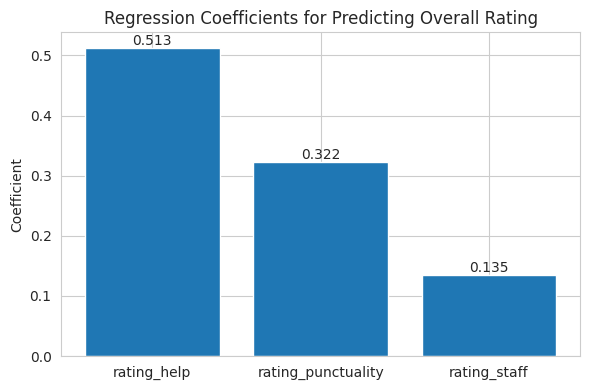

In [80]:


# a. Prepare data for regression
# Select the sub-rating predictors
X = df_clean[["rating_help", "rating_punctuality", "rating_staff"]]

# b.Add an intercept term for OLS regression
X = sm.add_constant(X)

# c.Target variable: overall rating
y = df_clean["rating_avg"]

# d. Fit regression model
model = sm.OLS(y, X).fit()

# e.Display full regression summary in notebook
print("Regression Summary:")
display(model.summary())

# f. Extract coefficients (excluding intercept)
coefs = model.params.drop("const")
coef_df = coefs.reset_index()
coef_df.columns = ["Sub_rating", "Coefficient"]

# g. Plot coefficients directly in notebook
plt.figure(figsize=(6,4))
bars = plt.bar(
    coef_df["Sub_rating"],
    coef_df["Coefficient"]
)

plt.title("Regression Coefficients for Predicting Overall Rating")
plt.ylabel("Coefficient")

# h.Label each bar with numeric value
for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        h,
        f"{h:.3f}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()


***Multiple Linear Regression (Overall Rating = Helpfulness + Punctuality + Staff):***

**Raw OLS coefficients:**
- rating_help = 0.513
- rating_punctuality = 0.322
- rating_staff = 0.135

These coefficients come directly from the original unstandardized regression.
They depend on:
- the scale of each sub-rating
- how much variation each sub-rating has
- the correlation structure among the variables

**Standardized Coefficients (Beta weights):**
To compare the relative influence of each sub-rating on the overall score in a common unit, we standardized (z-scored) all four variables and refit the OLS model:
- Helpfulness (rating_help): 0.625
- Punctuality (rating_punctuality): 0.392
- Staff (rating_staff): 0.165
These standardized coefficients tell if all predictors and the outcome are converted to z-scores (mean 0, sd 1) for standarization, then which variable has the strongest unique contribution.

**Interpretation**:
Even after accounting for scale differences, helpfulness remains the strongest driver of overall rating, β ≈ 0.63, punctuality is the next strongest predictor, β ≈ 0.39, and staff interactions have a smaller yet meaningful effect, β ≈ 0.17. This confirms that while all three factors are significant, patients place most weight on perceived helpfulness. (all p-values < 0.001, R² = 0.93)


## Conclusion

The differences in ratings across specialties are closely tied to both patient experience and clinical quality. High-rated specialties tend to be associated with good communication and strong technical competence, while low-rated specialties are more strongly linked to communication problems, delays, and negative interactions.

After Linear regression and pearson correlation analysis it is concluded that helpfulness is by far the strongest predictor of a doctor’s overall rating, followed by staff interactions. Punctuality, while still significant, has a smaller effect. Patients prioritize the perceived helpfulness of their clinician when forming their overall satisfaction.

## References

1. Severance, Charles. Python for Everybody. Runestone Academy, 2013.
2. McKinney, Wes. Python for Data Analysis. O’Reilly Media, 2017.
3. Donabedian, A. (1988). The quality of care. How can it be assessed? Journal of the American Medical Association, 260(12), 1743–1748.
4. Seabold, S., & Perktold, J. (2010). “Statsmodels: Econometric and Statistical Modeling with Python.” Proceedings of the 9th Python in Science Conference, 61–66.